In [3]:
import pandas as pd
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import xarray as xr

# Load data

In [4]:
basin = 0
flag = 'iter0_trial0'
year=2010
file=f'/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/disaggregation/surfdata_CAMELS_level1_hist_78pfts_CMIP6_simyr2000_HAND_trapezoidal_{basin}.nc'
ds_surf = xr.load_dataset(file)
mesharea = ds_surf.AREA.values

In [5]:
# mosart river flow
# inpath = f'/glade/derecho/scratch/guoqiang/CTSM_outputs/CAMELS_Calib/Calib_HH_emulator/level1_{basin}/level1_{basin}/run'
inpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_{basin}_calib/ctsm_outputs/{flag}/rof/hist'
files = glob.glob(f'{inpath}/level1_*.mosart.h1.{year}-*.nc')
files.sort()
ds_mosart = xr.open_mfdataset(files)

In [6]:
# clm runoff
inpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_{basin}_calib/ctsm_outputs/{flag}/lnd/hist'
files = glob.glob(f'{inpath}/level1_*.clm2.h1.{year}-*.nc')
files.sort()
ds_clm = xr.open_mfdataset(files)
ds_clm['QRUNOFF'].values = (ds_clm['QRUNOFF'].values / 1000) * (mesharea * 1e6)

In [10]:
# mizuroute runoff
inpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_{basin}_calib/ctsm_outputs/{flag}/mizuroute/'
files = glob.glob(f'{inpath}/sflow.h*.nc')
files.sort()
ds_mizu = xr.open_mfdataset(files)

ind = np.argmax(ds_mizu['DWroutedRunoff'].mean(dim='time').values)
ds_mizu = ds_mizu.isel(seg=ind)

ds_mizu = ds_mizu.sel(time=slice(ds_mosart.time[0], ds_mosart.time[-1]))
ds_mizu = ds_mizu.load()


In [20]:
inpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_{basin}_calib/ctsm_outputs/{flag}/mizuroute/'
files = glob.glob(f'{inpath}/sflow.h*.nc')
files.sort()
ds_mizu = xr.open_mfdataset(files)
ds_mizu = ds_mizu.load()

In [21]:
ds_mizu 

<xarray.Dataset> Size: 132kB
Dimensions:         (time: 2191, tbound: 2, hru: 9, seg: 9)
Coordinates:
  * time            (time) object 18kB 2008-10-01 00:00:00 ... 2014-10-01 00:...
Dimensions without coordinates: tbound, hru, seg
Data variables:
    time_bounds     (time, tbound) object 35kB 2008-10-01 00:00:00 ... 2014-1...
    basinID         (hru) int32 36B 0 0 0 0 0 0 0 0 0
    reachID         (seg) int32 36B 73000670 73000689 ... 73001248 73001297
    DWroutedRunoff  (time, seg) float32 79kB 4.571e-09 3.852e-09 ... 1.037e-07
Attributes:
    mizuRoute-version:  cesm-coupling.n02_v2.1.4-standalone
    gitBranch:          tags/cesm-coupling.n02_v2.1.4-standalone-0-gdae5db8
    gitHash:            dae5db8a5f2fed5f80b6f841d888f715e1d5e36a

In [11]:
# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file)
df_info.iloc[basin]

hru_id                                                     1022500
ann_P                                                          0.0
lon_cen                                                  -68.07313
lat_cen                                                   44.79691
AREA                                                 620387273.442
elev_mean                                                 103.6042
ave_T                                                          NaN
july_T                                                         NaN
Perimeter                                                   312624
Source                                                       HSTDX
latoutlet                                                 44.60797
lonoutlet                                                -67.93524
areaUSGS                                                     573.6
RawCAMELSarea                                           620.387273
RawTDXarea                                              615.17

In [12]:
# observed streamflow
def read_CAMELS_Q(file_Qobs):
    df_q_in = pd.read_csv(file_Qobs, delim_whitespace=True, header=None)
    years = df_q_in[1].values
    months = df_q_in[2].values
    days = df_q_in[3].values
    dates = [f'{years[i]}-{months[i]:02}-{days[i]:02}' for i in range(len(years))]
    dates = pd.to_datetime(dates)
    q_obs = df_q_in[4].values * 0.028316847  # cfs to cms
    q_obs[q_obs < 0] = -9999.0
    df_q_out = pd.DataFrame({'Date': dates, 'Runoff_cms': q_obs})
    
    # fill possible missing values
    df_q_out.set_index('Date', inplace=True)
    date_range = pd.date_range(start=dates[0], end=dates[-1], freq='D')
    df_q_out = df_q_out.reindex(date_range)
    df_q_out.fillna(-9999, inplace=True)
    df_q_out.reset_index(inplace=True)
    df_q_out = df_q_out.rename(columns={'index': 'Date'})

    return df_q_out
    
id = df_info.iloc[basin]['hru_id']
file = f'/glade/work/guoqiang/CTSM_CAMELS/CAMLES_Qobs/{id:08}_streamflow_qc.txt'
df_qobs = read_CAMELS_Q(file)

/glade/derecho/scratch/guoqiang/tmp/ipykernel_22267/3664160885.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_q_in = pd.read_csv(file_Qobs, delim_whitespace=True, header=None)


# Plot curves

In [13]:
ds_mosart.time

<xarray.DataArray 'time' (time: 365)> Size: 3kB
array([cftime.DatetimeNoLeap(2010, 10, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2010, 10, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2010, 10, 4, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2011, 9, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2011, 9, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2011, 10, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 3kB 2010-10-02 00:00:00 ... 2011-10-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bounds

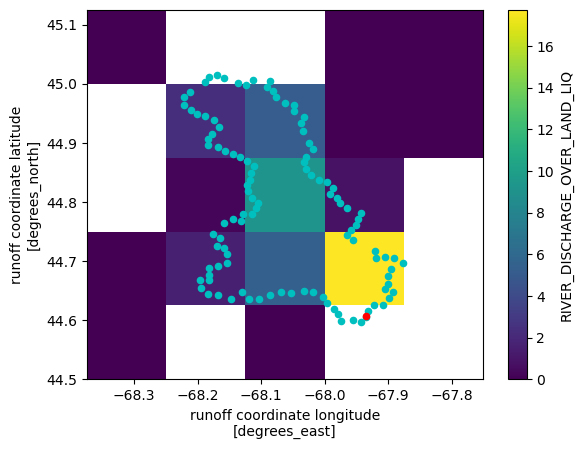

In [14]:
# plot basin location

latb = df_info.iloc[basin]['latoutlet']
lonb = df_info.iloc[basin]['lonoutlet']

file_mesh = f'/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/disaggregation/corrected_HCDN_nhru_final_671_buff_fix_holes.CAMELSandTDX_areabias_fix.simp0.001.level1_polygons_neighbor_group_esmf_mesh_{basin}.nc'
ds_basin = xr.load_dataset(file_mesh)
nodeCoords = ds_basin.nodeCoords.values

ds_mosart.RIVER_DISCHARGE_OVER_LAND_LIQ.mean(dim='time').plot()
plt.scatter(nodeCoords[:,0]-360, nodeCoords[:,1], 20, color='c')
plt.scatter(lonb, latb, 20, color='r')

368450000.0 822675778.0644157


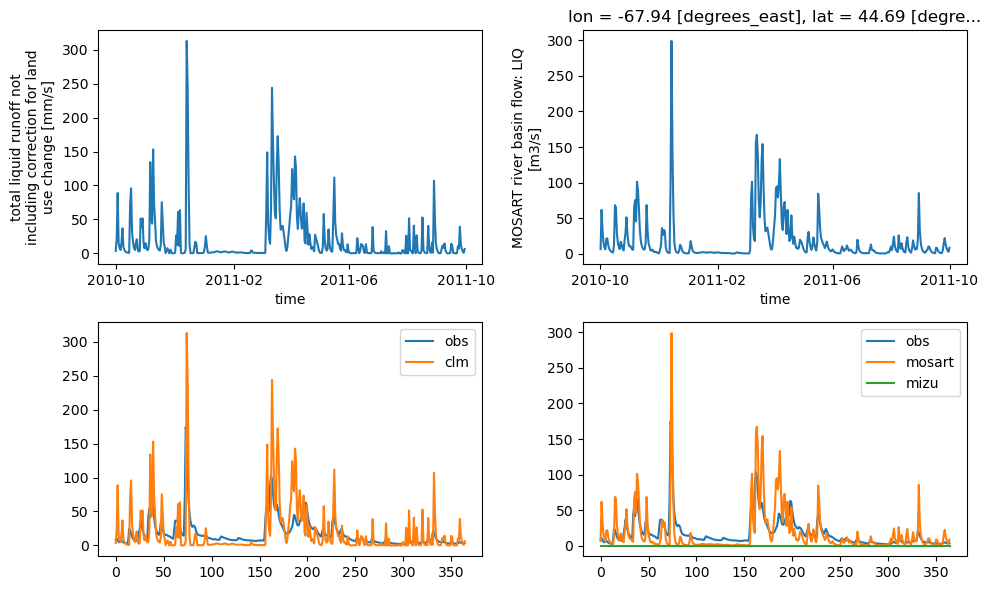

In [15]:
fig = plt.figure(figsize=[10, 6])

fig.add_subplot(2,2,1)
ds_clm.QRUNOFF.plot()

fig.add_subplot(2,2,2)
# mosart: find the grid with the largest mean flow
mean_values = ds_mosart.RIVER_DISCHARGE_OVER_LAND_LIQ.mean(dim='time')
m1, m2 = np.unravel_index(np.nanargmax(mean_values.values), mean_values.shape)  # Get the indices
ds_mosart_max = ds_mosart.RIVER_DISCHARGE_OVER_LAND_LIQ.isel(lat=m1, lon=m2)
print(ds_mosart.areatotal.isel( lat=m1, lon=m2).values, ds_mosart.areatotal2.isel( lat=m1, lon=m2).values)
ds_mosart_max.plot()

fig.add_subplot(2,2,3)
dobs = df_qobs[ (df_qobs['Date']>=f'{year}-10-02') & (df_qobs['Date']<=f'{year+1}-10-01') ]['Runoff_cms'].values
dobs[dobs<0]=np.nan
dclm = ds_clm.QRUNOFF.values

plt.plot(dobs, label='obs')
plt.plot(dclm, label='clm')
plt.legend()

fig.add_subplot(2,2,4)
dobs = df_qobs[ (df_qobs['Date']>=f'{year}-10-02') & (df_qobs['Date']<=f'{year+1}-10-01') ]['Runoff_cms'].values
dobs[dobs<0]=np.nan
dmosart = ds_mosart_max.values
dmizu = ds_mizu.DWroutedRunoff.values

plt.plot(dobs, label='obs')
plt.plot(dmosart, label='mosart')
plt.plot(dmizu, label='mizu')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
ds=xr.load_dataset('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_0_calib/ctsm_outputs/iter0_trial3/mizuroute/sflow.h.2008-10-01-00000.nc')
ds.DWroutedRunoff.mean(dim='time')

<xarray.DataArray 'DWroutedRunoff' (seg: 51)> Size: 204B
array([14.697724  , 13.294281  , 12.936503  ,  7.315862  ,  6.9825745 ,
        5.9996314 ,  4.413209  ,  3.4917803 ,  2.8452418 ,  1.770615  ,
        1.4361285 ,  0.60153824,  0.37036794,  0.22875494,  0.59584177,
        0.22700365,  0.22600546,  0.30797124,  0.38313398,  0.27339065,
        0.26828963,  1.5715439 ,  0.8474257 ,  0.51160735,  0.7273677 ,
        0.37855935,  0.21548302,  0.26013836,  5.0893564 ,  4.5301914 ,
        3.9083369 ,  2.731004  ,  1.6607134 ,  1.1673969 ,  0.48604098,
        0.5722065 ,  0.21075074,  0.8222883 ,  0.48298398,  0.1928926 ,
        0.24646851,  0.2736911 ,  1.0169516 ,  0.49808732,  0.31821734,
        0.3334865 ,  0.37772888,  0.24097721,  1.1609648 ,  0.5327028 ,
        0.17231104], dtype=float32)
Dimensions without coordinates: seg

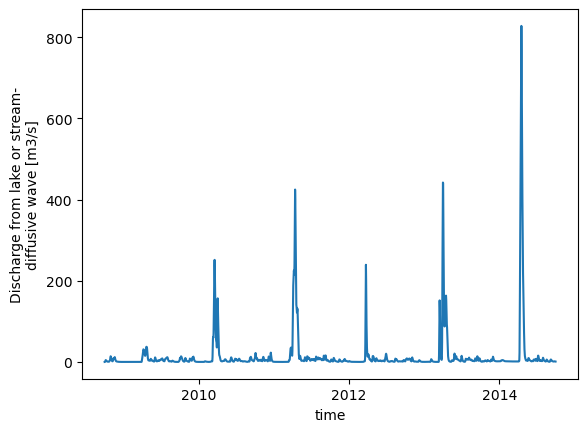

In [45]:
ds.DWroutedRunoff.isel(seg=0).plot()

In [41]:
ds=xr.load_dataset('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_1_calib/ctsm_outputs/iter0_trial0/mizuroute/sflow.h.2008-10-01-00000.nc')
ds.mean(dim='time')

<xarray.Dataset> Size: 108B
Dimensions:         (hru: 9, seg: 9)
Dimensions without coordinates: hru, seg
Data variables:
    basinID         (hru) int32 36B 0 0 0 0 0 0 0 0 0
    reachID         (seg) int32 36B 73000670 73000689 ... 73001248 73001297
    DWroutedRunoff  (seg) float32 36B 17.39 10.7 8.621 ... 5.831 1.093 2.936

In [32]:
ds=xr.load_dataset('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_1_calib/ctsm_outputs/iter0_trial0/mizuroute/CTSM_runoff_2008-10-01-to-2014-10-01.nc')
ds

<xarray.Dataset> Size: 26kB
Dimensions:  (time: 2191, gru: 1)
Coordinates:
  * time     (time) object 18kB 2008-10-01 00:00:00 ... 2014-10-01 00:00:00
  * gru      (gru) int64 8B 0
Data variables:
    QRUNOFF  (time, gru) float32 9kB 3.726e-05 3.103e-05 ... -9.617e-08
    gruId    (gru) int64 8B 0
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 10/09/24 20:53:31
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     day_1

In [38]:
ds.coords['gru']=[1022500]

In [40]:
ds.to_netcdf('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_1_calib/ctsm_outputs/iter0_trial0/mizuroute/CTSM_runoff_2008-10-01-to-2014-10-01.nc')

In [39]:
ds

<xarray.Dataset> Size: 26kB
Dimensions:  (time: 2191, gru: 1)
Coordinates:
  * time     (time) object 18kB 2008-10-01 00:00:00 ... 2014-10-01 00:00:00
  * gru      (gru) int64 8B 1022500
Data variables:
    QRUNOFF  (time, gru) float32 9kB 3.726e-05 3.103e-05 ... -9.617e-08
    gruId    int64 8B 1022500
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 10/09/24 20:53:31
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     day_1